## Manuscript Plots

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
from matplotlib import collections  as mc

from tqdm import tnrange

In [3]:
import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
from cvtk.plots import correction_diagnostic_plot
from cvtk.bootstrap import bootstrap_ci

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (6.0, 2.50)
mpl.rcParams['figure.dpi'] = 200

In [6]:
# image sizes
ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7

## Barghi et al (2019) Combined Plots

In [7]:
barghi_gw_temp_covs_cis = np.load("../../data/barghi_et_al_2019/gw_temp_covs_cis.npy")
barghi_g_cis_averep = np.load("../../data/barghi_et_al_2019/g_cis_averep.npy")
barghi_g = np.load("../../data/barghi_et_al_2019/g.npy")

In [7]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = 2*ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        #ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #markersize=4.3)# markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

In [8]:
def G_plot(g, g_averep_cis=None, alpha=1, point_alpha=1, linewidth=1, ax=None, 
           ylim=None, xlim=None, as_percent=True, hline=True, cmap=None, ci_col='0.2',
           rep_markersize=0):
    if ax is None:
        fig, ax = plt.subplots()
    T, R = g.shape
    y_multiplier = 100. if as_percent else 1.
    x = np.arange(1, T+1) * 10
    cmap = cm.viridis if cmap is None else cmap
    cols = cmap(np.linspace(0, 1, T-1))
    for rep in range(R):
        for t in range(T-1):
            xa = x[t:(t+2)]
            mean = g[t:(t+2), rep]
            #import pdb; pdb.set_trace()
            ax.plot(xa, y_multiplier*mean, '-o', linewidth=linewidth, c=cols[t],
                    alpha=alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')  #markeredgecolor='w')
            ax.plot(xa, y_multiplier*mean, 'o', linewidth=linewidth, c=cols[t],
                    alpha=point_alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')#,  markeredgecolor='w')
            
    if g_averep_cis is not None:
        mean = g_averep_cis[1, :]
        lower, upper = g_averep_cis[0, :]-mean, mean-g_averep_cis[2, :]
        ax.plot(x, y_multiplier*mean, '-o', linewidth=linewidth, c=ci_col, markerfacecolor='w',
                zorder=1e4, markersize=2)#, markeredgecolor='w', markeredgewidth=3)
        ax.errorbar(x, y_multiplier*mean, yerr=y_multiplier*np.column_stack([lower.ravel(), upper.ravel()]).T, 
                     capsize=0, elinewidth=linewidth*1.3, linewidth=0,
                     zorder=1e5, alpha=1, c=ci_col, label=None, solid_capstyle='round')
        ax.plot(x, y_multiplier*mean, 'o', linewidth=linewidth, c='k',
               zorder=np.Inf, markersize=2.1)
        

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-100, linestyle='--')

    ax.set_xlabel("generation ($t$)")
    ax.set_ylabel("$G(t)$")

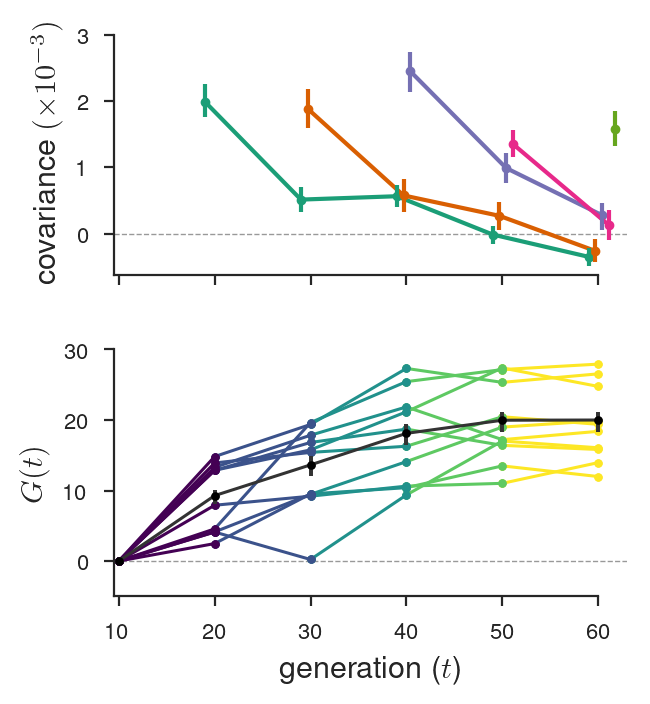

In [9]:
#plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.style.use('./buffalo.mplstyle')

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

cov_plot(barghi_gw_temp_covs_cis, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1.5, xticks=np.arange(0, 63, 10))
G_plot(barghi_g, barghi_g_cis_averep, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1.1, alpha=1, rep_markersize=2)


# customize plots
#ax[0].spines['bottom'].set_bounds(10, 60)
#ax[0].spines['bottom'].set_bounds(9.7, 60)
#ax[0].spines['left'].set_bounds(-0.6, 2)
#ax[0].spines['left'].set_bounds(0, 2)  # end top y axis at 0
# this drops top y axis below 0
#ax[1].spines['left'].set_position(('axes', -0.01))
# this combines the top y axis with the x axis
#ax[0].spines['left'].set_position(('axes', 0.01))
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[0].yaxis.set_major_formatter(mtick.LogFormatterMathtext())

#ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"${int(x)}\\%$"))

# uncomment if you don't want latex tick labels
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}%"))
# ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}"))

ax[0].spines['bottom'].set_bounds(9.5, 60)
ax[1].spines['bottom'].set_bounds(9.5, 60)
ax[0].spines['left'].set_bounds(-0.63, 3)
ax[0].set_ylim(-0.63, 3.1)
ax[1].spines['left'].set_bounds(-5, 30)
#ax[1].spines['left'].set_bounds(-3, 20)
#ax[1].spines['left'].set_bounds(0, 20)

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=.4)
fig.savefig("figure-1-G-covs.pdf", bbox_inches='tight')

In [10]:
barghi_g_cis_averep

array([[0.        , 0.08542407, 0.12448255, 0.16845072, 0.18751367,
        0.18883686],
       [0.        , 0.09278597, 0.13635574, 0.18102241, 0.19962738,
        0.19991532],
       [0.        , 0.10479589, 0.15235281, 0.19787816, 0.2167262 ,
        0.21642803]])

## Castro et al (2019)

In [24]:
castro_covs_cis = np.load("../../data/castro_et_al_2019/castro_et_al_2019_covs_bootstrap.npy")

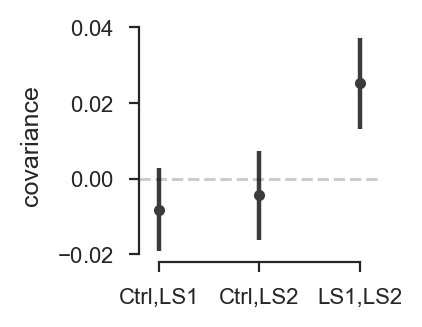

In [25]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = castro_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = castro_covs_cis[0]-mean, mean-castro_covs_cis[2]
#comps = [('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS1}$)', 0, 1), ('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS2}$)', 0, 2), ('cov($\Delta p_\mathrm{LS1}, \Delta p_\mathrm{LS2}$)', 1, 2)]
comps = [('Ctrl,LS1', 0, 1), 
         ('Ctrl,LS2', 0, 2), 
         ('LS1,LS2', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()    
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')

ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(0, 2)
#ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('covariance', fontsize=9) #, fontsize=13)
ax.set_xlim(-0.2, 2.2)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")


## Kelly and Hughes (2019)

In [28]:
kh_covs_cis = np.load("../../data/kelly_hughes_2019/kelly_hughes_2019_covs_bootstrap.npy")

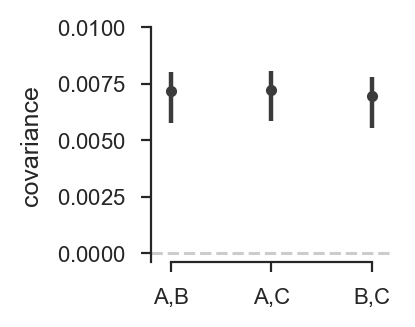

In [29]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = kh_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = kh_covs_cis[0]-mean, mean-kh_covs_cis[2]
comps = [('A,B', 0, 1), 
         ('A,C', 0, 2), 
         ('B,C', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')


#ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(-0, 2)
ax.spines['left'].set_bounds(-0.0004, 0.01)
#ax.tick_params(axis='both', which='major', labelsize=10)
#plt.ylabel('covariance', fontsize=13)
ax.set_ylim(-0.0004, 0.01)
ax.set_xlim(-0.2, 2.2)
plt.ylabel('covariance', fontsize=9)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
#plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")
plt.savefig('kh_rep_cis.pdf', bbox_inches="tight")



### Barghi Convergence Correlation Plot

In [30]:
barghi_conv_corr_cis = np.load("../../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis.npy")[:, 0, ...]

In [31]:
def convcorr_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, refgen:]
        lower, upper = y_multiplier*cov_cis[0][refgen, refgen:]-mean, mean-y_multiplier*cov_cis[2][refgen, refgen:]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x, mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.) #, markersize=3., markeredgecolor='w')
        #ax.plot(x, mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #, markersize=3.5, markeredgecolor='w')
        ax.errorbar(x, mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

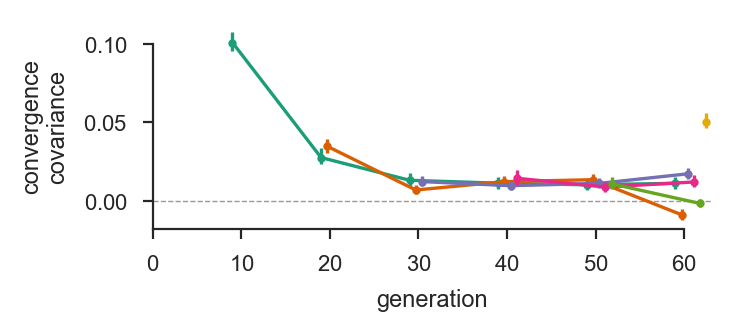

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(THREEHALVESCOL*0.8, ONECOL/2.5))

convcorr_plot(barghi_conv_corr_cis, ax=ax, ngens=10, xlim=(9.5, 63), y_multiplier=None, linewidth=1.2,
              xticks=np.arange(0, 63, 10), ylab='convergence\ncorrelation')

ax.set_xlabel("generation", fontsize=8.5)
ax.set_ylabel("convergence\ncovariance", fontsize=8.5)


ax.spines['left'].set_bounds(-0.018, 0.1)
ax.spines['bottom'].set_bounds(0, 60)
fig.savefig("figure-2-corr.pdf", bbox_inches='tight')

## Empirical Null

In [13]:
barghi_emp_null_tile = np.load('../../data/barghi_et_al_2019/empnull_tile_1e5.npy')
barghi_emp_null_seqid = np.load('../../data/barghi_et_al_2019/empnull_seqid_1e5.npy')
barghi_tile_covs = np.load('../../data/barghi_et_al_2019/tile_temporal_covs_1e5.npy')

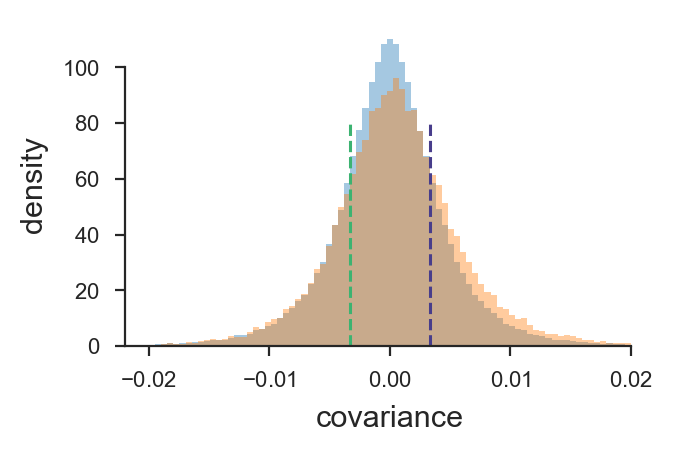

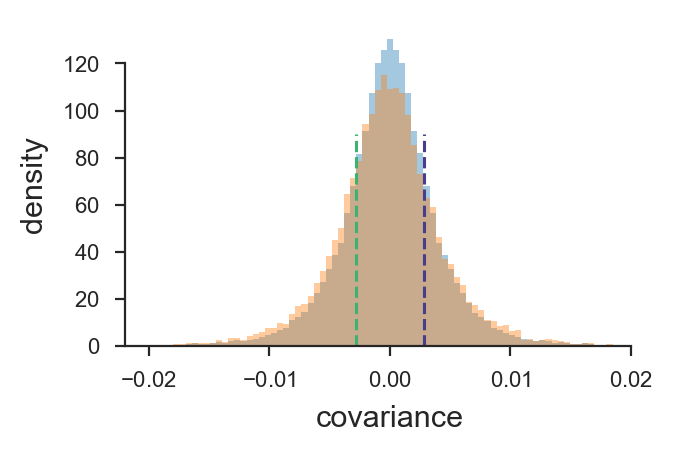

In [392]:
plt.rc('text', usetex=False)

def cov_hist(empnull, real, rep=None, k=2, bins=np.linspace(-0.03, 0.03, 50), alpha=0.4,
             ax=None, fontsize=10,
             empnull_label='sign-permuted\nneutral null', real_label='observed covariance',
             xlabel='covariance', ylabel='density'):
    assert(empnull.ndim == 5)
    rep = slice(None) if rep is None else rep
    # empnull is npermutations x nblocks x T x T x R
    # real is nblocks x T x T x R
    # after extracting diagonal, empnull_covs is npermutations x nblocks x R x U where U is elements
    # among diagonal k
    empnull_covs = np.diagonal(empnull, offset=k, axis1=2, axis2=3)[:, :, rep, :].ravel()
    real_covs = np.diagonal(real, offset=k, axis1=1, axis2=2)[:, rep, :].ravel()
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(empnull_covs, bins, alpha=alpha, density=True, label=empnull_label)
    ax.hist(real_covs, bins, alpha=alpha, density=True, label=real_label)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    return ax

alpha = 0.2
upper_tail_color='darkslateblue'
lower_tail_color='mediumseagreen'

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, 80),
         fontsize=11)

upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile, 2, 2, 3), (alpha, 1-alpha))
tail_segments = [[(lower_tail, 0), (lower_tail, 80)],
                 [(upper_tail, 0), (upper_tail, 80)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 100)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-a.pdf", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, 80),
         fontsize=11)
upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile, 4, 2, 3), (alpha, 1-alpha))
#ax.legend(loc=(0.8,0.5))
tail_segments = [[(lower_tail, 0), (lower_tail, 90)],
                 [(upper_tail, 0), (upper_tail, 90)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 120)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-b.pdf", bbox_inches='tight')
#ax[1].text(-0.02, 240, "permuted tile blocks")

### P-value calculation

This pools all replicates.

In [11]:
def tail_probs(empnull, real, alpha=0.01):
    tails = np.nanquantile(empnull, (alpha, 1-alpha))
    lt, rt = np.nanmean(real < tails[0]), np.nanmean(real > tails[1])
    return lt, rt

def bootstrap_tail_probs(empnull, real, B=1000, alpha=0.01, progress_bar=False):
    nperms, nblocks, T, T_, R = empnull.shape
    straps = []
    B_range = tnrange(B) if progress_bar else np.arange(B)
    # pre-cache all of the elements along each diagonal.
    real_ks = {k: np.diagonal(real, offset=k, axis1=1, axis2=2) for k in np.arange(1, T)}
    empnull_ks = {k: np.swapaxes(np.diagonal(empnull, offset=k, axis1=2, axis2=3), 0, 1) for k in np.arange(1, T)}
    for b in B_range:
        bidx = np.random.randint(0, nblocks, size=nblocks)
        #import pdb; pdb.set_trace()
        straps.append([tail_probs(empnull_ks[k][bidx,:  :, :], real_ks[k], alpha=alpha) for k in np.arange(1, T)])
    return straps

def plot_tail_probs(tail_prob_cis, ax=None, alpha=0.01, fontsize=11,
                    upper_tail_color='darkslateblue', lower_tail_color='mediumseagreen'):
    mean = tail_prob_cis[1]
    lower, upper = tail_prob_cis[0] - mean, mean - tail_prob_cis[2]
    k = np.arange(2, 6)
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(k+0.05, mean[:, 0], np.stack((lower[:, 0], upper[:, 0])),
                label='left', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=lower_tail_color)
    ax.errorbar(k-0.05, mean[:, 1], np.stack((lower[:, 1], upper[:, 1])),
                label='right', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=upper_tail_color)
    ax.set_xticks(k)
    ax.axhline(y=alpha, c='k', alpha=0.2, linestyle='--', zorder=-1)
    ax.set_xlabel('k', fontsize=fontsize)
    ax.set_ylabel(f'{int(100*alpha)}% tail prob', fontsize=fontsize)
    return ax


### Barghi Empirical Tail Probabilities for α=0.01

In [219]:
CACHED_EMPCOV_TAILPROB_01 = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.01.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB):
    empnull_tail_probs_bootstraps_01 = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs, B=1000, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_01, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps_01)
else:
    with open(CACHED_EMPCOV_TAILPROB_01, 'rb') as f:
        empnull_tail_probs_bootstraps_01 = np.load(f)
        
stats_01 = np.array([tail_probs(np.diagonal(barghi_emp_null_tile, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2)) 
                     for k in np.arange(1, T)])

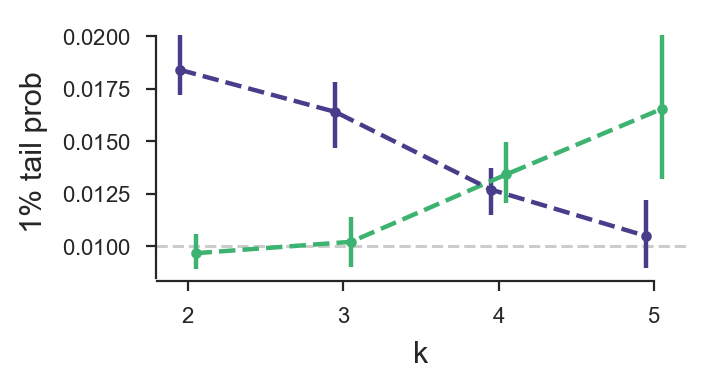

In [401]:
tail_probs_cis_01 = bootstrap_ci(stats_01, empnull_tail_probs_bootstraps_01)

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax, alpha=0.01)
ax.spines['left'].set_bounds(0.0085, 0.02)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.01.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.1

In [278]:
CACHED_EMPCOV_TAILPROB_10 = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.10.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB_10):
    empnull_tail_probs_bootstraps_10 = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs, 
                                                                     B=1000, alpha=0.1, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_10, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps)
else:
    with open(CACHED_EMPCOV_TAILPROB_10, 'rb') as f:
        empnull_tail_probs_bootstraps_10 = np.load(f)

stats_10 = np.array([tail_probs(np.diagonal(barghi_emp_null_tile, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2), alpha=0.1)
                     for k in np.arange(1, T)])

The tail probabilities start at k=1, the bias-corrected off diagonal — the permutation procedure does not account for this, so we don't plot it.

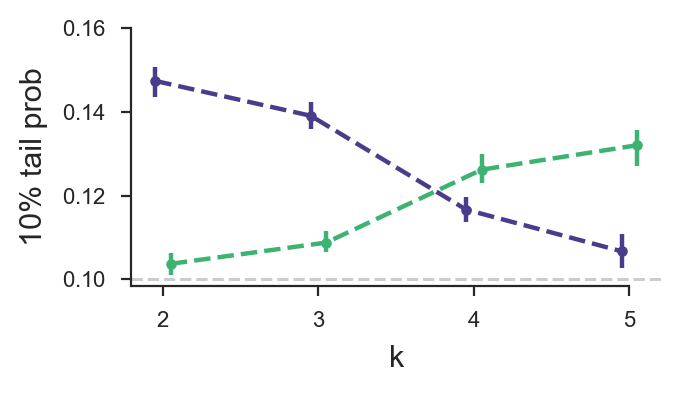

In [400]:
tail_probs_cis_10 = bootstrap_ci(stats_10, empnull_tail_probs_bootstraps_10)

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax, alpha=0.1)
ax.set_ylim(0.09838, 0.16)
ax.spines['left'].set_bounds(0.09838, 0.16)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.10.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.2

In [280]:
CACHED_EMPCOV_TAILPROB_20 = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB_20):
    empnull_tail_probs_bootstraps_20 = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs,
                                                                     B=1000, alpha=0.2, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_20, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps_20)
else:
    with open(CACHED_EMPCOV_TAILPROB_20, 'rb') as f:
        empnull_tail_probs_bootstraps_20 = np.load(f)

        
stats_20 = np.array([tail_probs(np.diagonal(barghi_emp_null_tile, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2), alpha=0.2) 
                     for k in np.arange(1, T)])

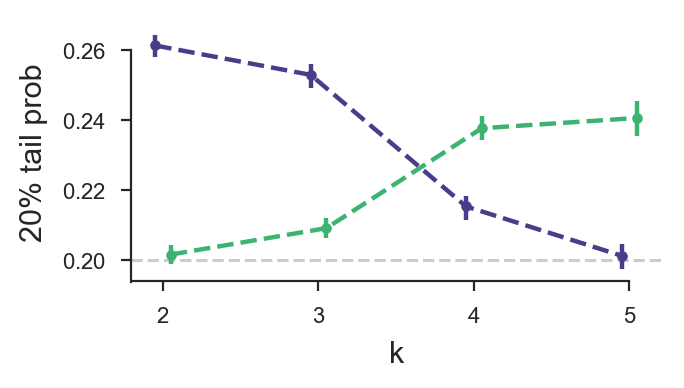

In [402]:
tail_probs_cis_20 = bootstrap_ci(stats_20, empnull_tail_probs_bootstraps_20)

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_20[:, 1:, :], ax=ax, alpha=0.2)
ax.spines['left'].set_bounds(0.194, 0.26)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.20.pdf", bbox_inches='tight')

In the manuscript, we cite the fold enrichment for α = 0.2; this generates those number:

In [495]:
tail_probs_cis_20[:, 1:, :] / 0.2

array([[[0.99434901, 1.29135963],
        [1.03149488, 1.24924653],
        [1.17088608, 1.06192925],
        [1.17947559, 0.98960217]],

       [[1.00847649, 1.30684901],
        [1.04611212, 1.26491863],
        [1.18874322, 1.07707957],
        [1.2034358 , 1.00678119]],

       [[1.02226492, 1.32392066],
        [1.06012658, 1.28300558],
        [1.20570185, 1.09606691],
        [1.22875226, 1.02625452]]])

### Barghi Empirical Tail Probabilities for α=0.05

In [353]:
CACHED_EMPCOV_TAILPROB_05 = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.05.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB_05):
    empnull_tail_probs_bootstraps_05 = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs, 
                                                                     B=1000, alpha=0.05, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_05, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps_05)
else:
    with open(CACHED_EMPCOV_TAILPROB_05, 'rb') as f:
        empnull_tail_probs_bootstraps_05 = np.load(f)
        
stats_05 = np.array([tail_probs(np.diagonal(barghi_emp_null_tile, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2), alpha=0.05) 
                     for k in np.arange(1, T)])

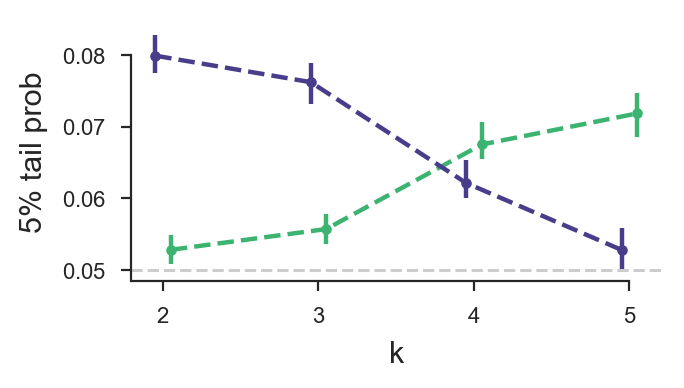

In [404]:
tail_probs_cis_05 = bootstrap_ci(stats_05, empnull_tail_probs_bootstraps_05)

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax, alpha=0.05)
ax.spines['left'].set_bounds(0.0485, 0.08)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.05.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.5

In [363]:
CACHED_EMPCOV_TAILPROB_50 = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.5.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB_50):
    empnull_tail_probs_bootstraps_50 = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs,
                                                                     B=1000, alpha=0.5, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_50, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps_50)
else:
    with open(CACHED_EMPCOV_TAILPROB_50, 'rb') as f:
        empnull_tail_probs_bootstraps_50 = np.load(f)

stats_50 = np.array([tail_probs(np.diagonal(barghi_emp_null_tile, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2), alpha=0.5) 
                     for k in np.arange(1, T)])

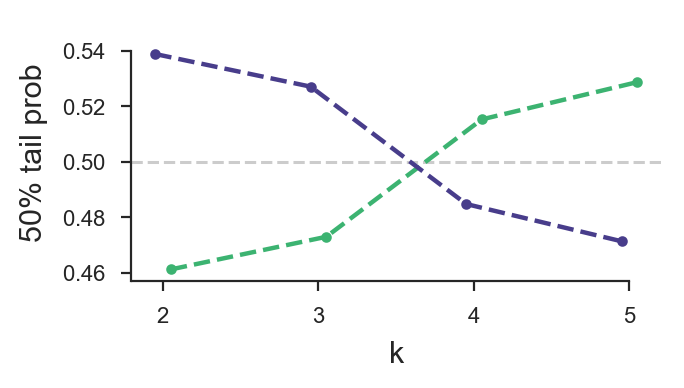

In [406]:
tail_probs_cis_50 = bootstrap_ci(stats_50, empnull_tail_probs_bootstraps_50)

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax, alpha=0.5)
ax.set_ylim(0.457, 0.55)
ax.spines['left'].set_bounds(0.457, 0.54)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.50.pdf", bbox_inches='tight')

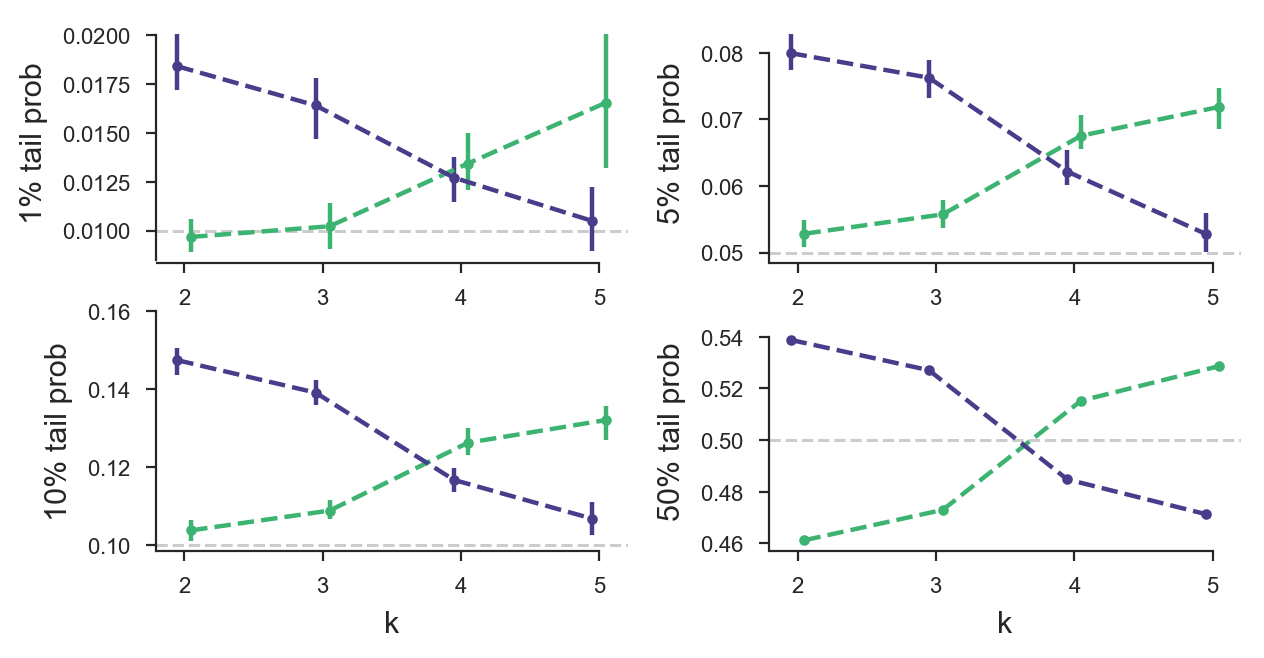

In [433]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/2))

plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax[0, 0], alpha=0.01)
ax[0, 0].spines['left'].set_bounds(0.0085, 0.02)
ax[0, 0].spines['bottom'].set_bounds(1.8, 5)
#ax[0, 0].text(3.5, 0.02, f"tail prob = 0.01", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax[0, 1], alpha=0.05)
ax[0, 1].spines['left'].set_bounds(0.0485, 0.08)
ax[0, 1].spines['bottom'].set_bounds(1.8, 5)
#ax[0, 1].text(3.5, 0.08, f"tail prob = 0.05", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax[1, 0], alpha=0.1)
ax[1, 0].set_ylim(0.09838, 0.16)
ax[1, 0].spines['left'].set_bounds(0.09838, 0.16)
ax[1, 0].spines['bottom'].set_bounds(1.8, 5)
#ax[1, 0].text(3.5, 0.16, f"tail prob = 0.10", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_ylim(0.457, 0.55)
ax[1, 1].spines['left'].set_bounds(0.457, 0.54)
ax[1, 1].spines['bottom'].set_bounds(1.8, 5)
#ax[1, 1].text(3.5, 0.54, f"tail prob = 0.50", horizontalalignment='center')

plt.subplots_adjust(wspace=.3)
fig.savefig("barghi-tailprobs-panels.pdf", bbox_inches='tight')


### More Barhi offset distribution plots

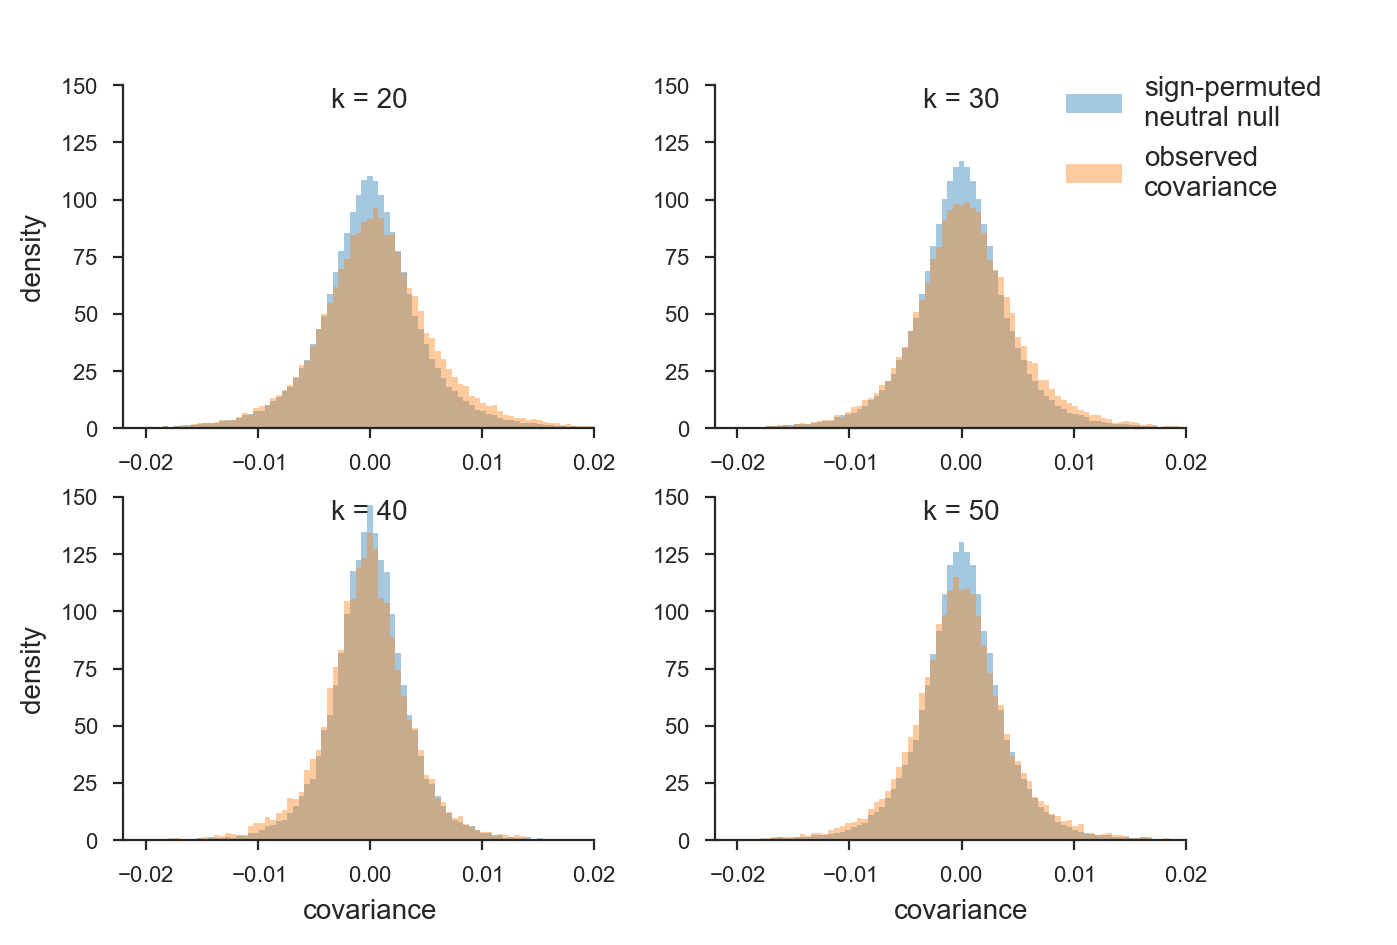

In [468]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/1.4))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, ax=ax[0, 0], 
         bins=np.linspace(-0.02, 0.02, 80), xlabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=3, rep=None, ax=ax[0, 1],
         bins=np.linspace(-0.02, 0.02, 80), xlabel='', ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, ax=ax[1, 1], 
         bins=np.linspace(-0.02, 0.02, 80), ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=5, rep=None, ax=ax[1, 0], 
         bins=np.linspace(-0.02, 0.02, 80), real_label='observed\ncovariance')
for k, (i, j) in enumerate([(i, j) for i in (0, 1) for j in (0, 1)], 2):
    ax[i, j].set_ylim([0, 150])
    ax[i, j].text(0, 140, f"k = {10*k}", horizontalalignment='center')
    ax[i, j].spines['bottom'].set_bounds(-0.022, 0.02)
    if i == 0 and j == 1:
        ax[i, j].legend(loc=(0.6, 0.5))

plt.savefig('barghi-offset-panels.pdf', bbox_inches="tight")

### Barghi Windowed Covariance Plot for Particular Replicates

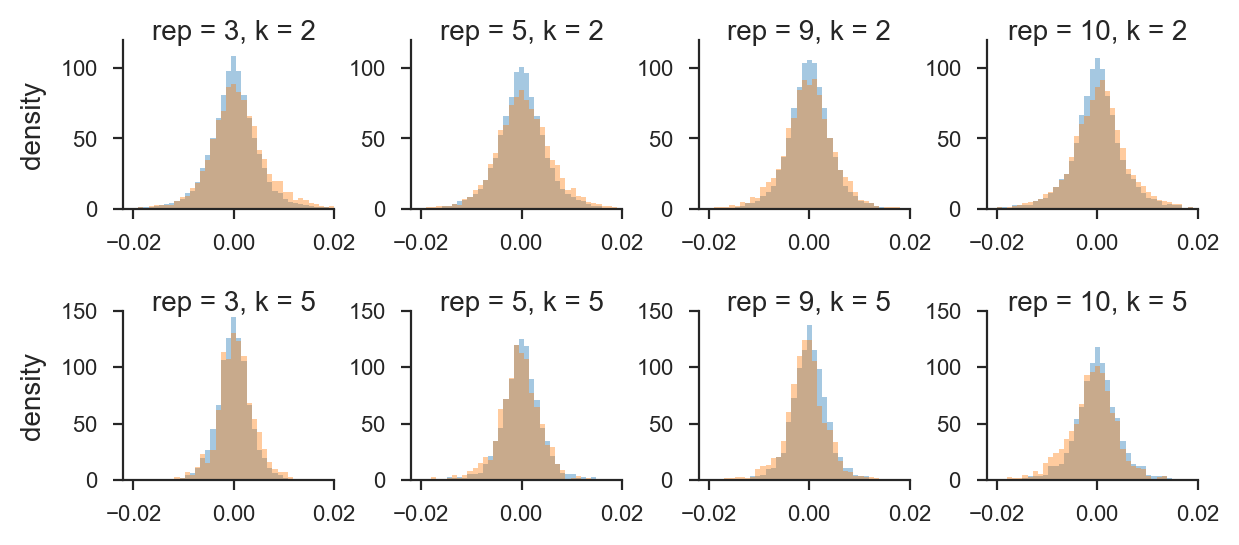

In [487]:
np.random.seed(0)
nreps = 4
fig, ax = plt.subplots(ncols=nreps, nrows=2, figsize=(TWOCOL, TWOCOL/2.4))

reps = sorted(np.random.choice(np.arange(10), replace=False, size=nreps))
ks = [2, 5]

for i in range(nreps):
    for j in (0, 1):
        ylabel = '' if i > 0 else 'density'
        cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=ks[j], ax=ax[j, i], rep=reps[i], 
             bins=np.linspace(-0.02, 0.02, 40), xlabel='', ylabel=ylabel, real_label='observed\ncovariance')
        ymax = 150 if j == 1 else 120
        ax[j, i].set_ylim(0, ymax)
        ax[j, i].spines['left'].set_bounds(0, ymax)
        ax[j, i].spines['bottom'].set_bounds(-0.022, 0.02)
        ax[j, i].text(0, ymax, f'rep = {reps[i]+1}, k = {ks[j]}', horizontalalignment='center')

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.savefig('barghi-offset-replicate-panels.pdf', bbox_inches="tight")

In [9]:
## Chromosome-level sign permutation

In [ ]:
CACHED_EMPCOV_TAILPROB_20_SEQID = '../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2_seqid.npy'
if not os.path.exists(CACHED_EMPCOV_TAILPROB_20_SEQID):
    empnull_tail_probs_bootstraps_20_seqid = np.array(bootstrap_tail_probs(barghi_emp_null_seqid, barghi_tile_covs,
                                                                     B=1000, alpha=0.2, progress_bar=True))
    with open(CACHED_EMPCOV_TAILPROB_20_SEQID, 'wb') as f:
        np.save(f, empnull_tail_probs_bootstraps_20_seqid)
else:
    with open(CACHED_EMPCOV_TAILPROB_20_SEQID, 'rb') as f:
        empnull_tail_probs_bootstraps_20_seqid = np.load(f)

        
stats_20 = np.array([tail_probs(np.diagonal(barghi_emp_null_seqid, k, 2, 3), np.diagonal(barghi_tile_covs, k, 1, 2), alpha=0.2) 
                     for k in np.arange(1, T)])

# Supplementary Plots

In [75]:
with open('../../data/barghi_et_al_2019/diagonistics_tuple.pkl', 'rb') as f:
    barghi_diagonistics = pickle.load(f)

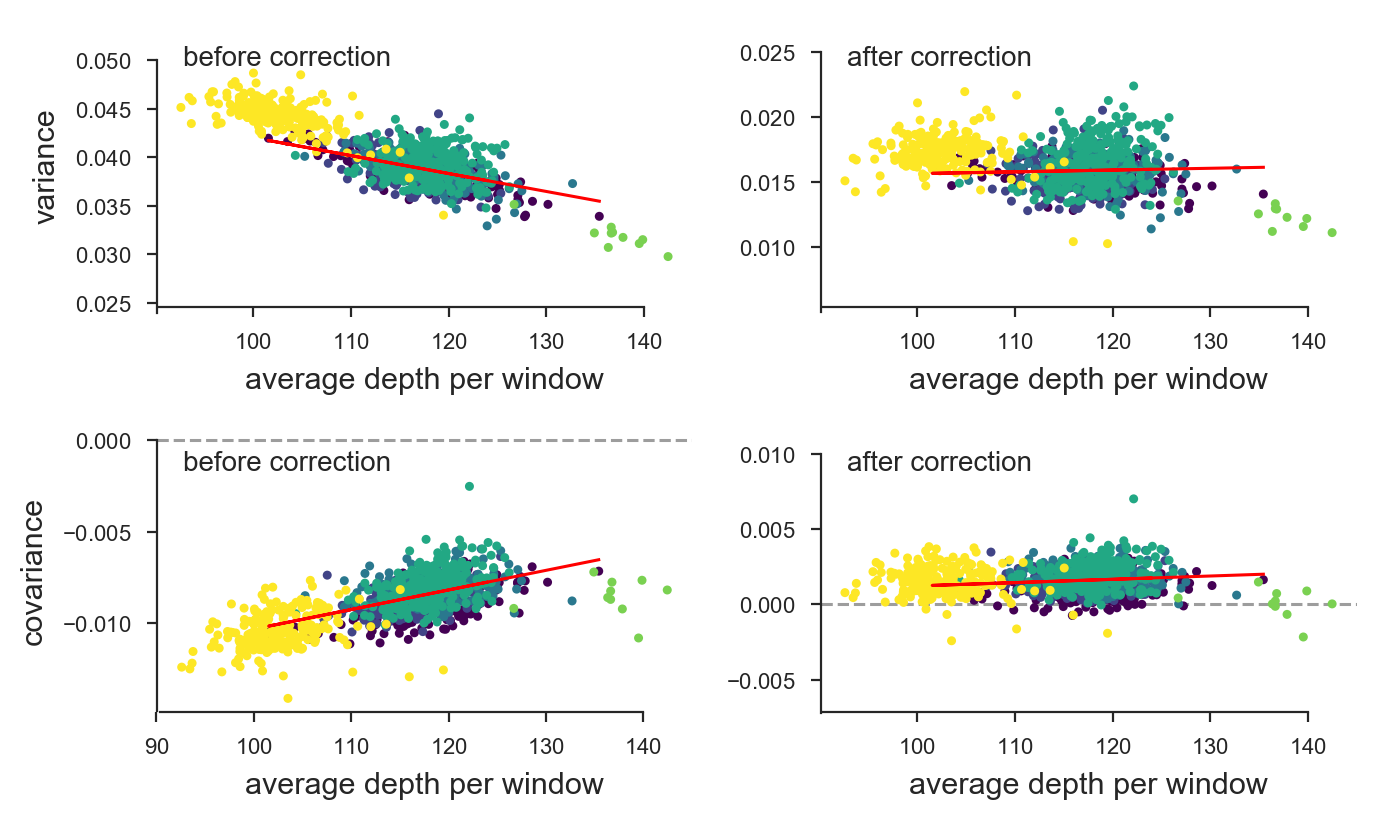

In [117]:
plt.rc('text', usetex=False)
fig, ax = correction_diagnostic_plot(barghi_diagonistics, figsize=(TWOCOL, TWOCOL*0.6))

ax[0, 0].spines['left'].set_bounds(0.024, 0.05)
ax[0, 0].spines['bottom'].set_bounds(90.4, 140)

ax[0, 1].spines['left'].set_bounds(0.005, 0.025)
ax[0, 1].spines['bottom'].set_bounds(90.4, 140)

ax[1, 0].spines['left'].set_bounds(-0.0148, 0.0)
ax[1, 0].spines['bottom'].set_bounds(90.4, 140)


ax[1, 1].spines['left'].set_bounds(-0.0072, 0.01)
ax[1, 1].spines['bottom'].set_bounds(90.4, 140)

plt.savefig('barghi-correction-plot.pdf', bbox_inches="tight")

# Old Stuff

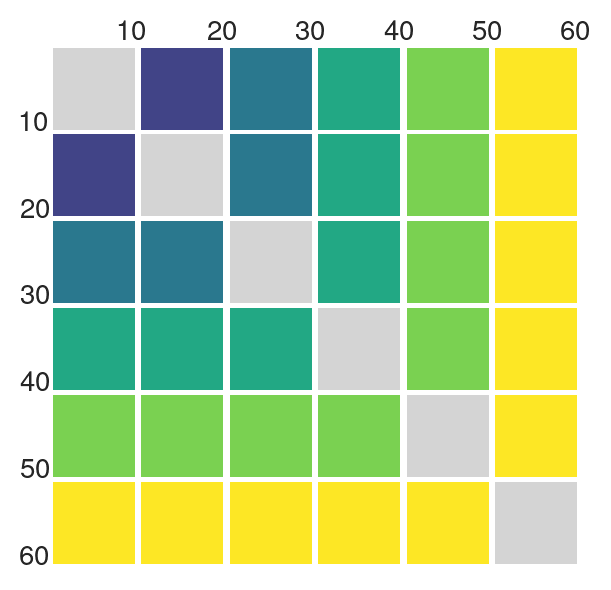

In [111]:
def make_grid(T):
    M = np.zeros((T, T))
    rows, cols = np.indices((T, T))
    for t in np.arange(T)[::-1]:
        M[(cols <= t) & (rows <= t)] = t
    np.fill_diagonal(M, np.nan)
    return M

#plt.imshow(make_grid(T))

# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(T, T)
# gs.update(wspace=0.01, hspace=0.04)

T = 6

fig, ax = plt.subplots(nrows=T, ncols=T, figsize=(ONECOL, ONECOL))
M = np.zeros((T, T))
rows, cols = np.indices((T, T))
bg_cols = cm.viridis(np.linspace(0, 1, T))

for t in np.arange(T)[::-1]:
    for r in np.arange(t):
        ax[r,t].set_facecolor(bg_cols[t])
        ax[t,r].set_facecolor(bg_cols[t])
    for r in np.arange(T):
        if r == t:
            ax[t,r].set_facecolor('44')
        ax[t, r].set_aspect('equal')
        ax[r, t].set_aspect('equal')
        
        ax[t, r].get_xaxis().set_visible(False)
        ax[r, t].get_xaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        
        ax[t, r].spines['top'].set_visible(False)
        ax[t, r].spines['right'].set_visible(False)
        ax[t, r].spines['left'].set_visible(False)
        ax[t, r].spines['bottom'].set_visible(False)
        if r == 0:
            ax[r, t].text(0.8, 1.1, (t+1)*10)
        if t == 0:
            ax[r, t].text(-0.4, 0, (r+1)*10)
plt.subplots_adjust(wspace=0.01, hspace=0.06)